In [66]:
%pip install gymnasium
%pip install stable_baselines3
%pip install stable_baselines


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2 -> 23.2.1
[notice] To update, run: C:\Users\12016\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2 -> 23.2.1
[notice] To update, run: C:\Users\12016\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2 -> 23.2.1
[notice] To update, run: C:\Users\12016\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [67]:
%pip install keras


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2 -> 23.2.1
[notice] To update, run: C:\Users\12016\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [68]:
%pip install --upgrade pip

  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/50/c2/e06851e8cc28dcad7c155f4753da8833ac06a5c704c109313b8d5a62968a/pip-23.2.1-py3-none-any.whl.metadata
   ---------------------------------------- 2.1/2.1 MB 2.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.2
    Uninstalling pip-23.2:
      Successfully uninstalled pip-23.2
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
import gym
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv
import numpy as np
from gym_anytrading.envs import StocksEnv
import gym_anytrading
import quantstats as qs
import pandas as pd
import matplotlib.pyplot as plt
import logging



In [27]:
logger = logging.getLogger('training')
logger.setLevel(logging.INFO)

file_handler = logging.FileHandler('training.log')
formatter = logging.Formatter('%(asctime)s - %(message)s')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

In [28]:
import yfinance as yf
vgt_data = yf.download("VGT", period = '5y')
voo_data = yf.download("VOO", period = '5y')

data = pd.concat([vgt_data, voo_data]) 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [29]:
#SIMPLE 80:20 SPLIT

split_index = int(len(data) * 0.8)
train_df = data[:split_index]
val_df = data[split_index:]

In [30]:
#Rolling window split. Two year training data

train_df = data[:2*365]
val_df_1 = data[2*365:3*365]
val_df_2 = data[3*365:4*365]
val_df_3 = data[4*365:5*365]

In [41]:
def ModelCreation():

    #Creating Logging env
    logger = logging.getLogger('training')
    logger.setLevel(logging.INFO)

    file_handler = logging.FileHandler('training.log')
    formatter = logging.Formatter('%(asctime)s - %(message)s')
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)

    #Creating training env

    window_size = 10
    start_index = window_size
    end_index = len(data)

    train_env = gym.make(
            'stocks-v0',
            df = train_df,
            window_size = window_size,
            frame_bound = (start_index, end_index)
        )

    val_env1 = gym.make(
        'stocks-v0',
        df = val_df_1,
        window_size = window_size,
        frame_bound = (start_index, end_index)
    )




    val_env2 = gym.make(
        'stocks-v0',
        df = val_df_2,
        window_size = window_size,
        frame_bound = (start_index, end_index)
    )



    val_env3 = gym.make(
        'stocks-v0',
        df = val_df_3,
        window_size = window_size,
        frame_bound = (start_index, end_index)
    )

    env = DummyVecEnv([lambda : train_env, lambda : val_env1, lambda : val_env2, lambda : val_env3])

    file_handler.close()
    logger.removeHandler(file_handler)

    file_handler = logging.FileHandler('training.log')
    logger.addHandler(file_handler)


    logger.info('Initializing the PPO and A2C models...')
    ppo_agent = PPO('MlpPolicy', train_env, verbose=1)
    a2c_agent = A2C('MlpPolicy', train_env, verbose=1)

    logger.info('Training the PPO Agent...')
    ppo_agent.learn(total_timesteps=1000)

    logger.info('Training the A2C Agent...')
    a2c_agent.learn(total_timesteps=1000)

    logger.info('Training is complete')

    

    def evalModel():
        ppo_rewards = []
        obs1 = val_env1.reset()

        while True:
            action, _ = ppo_agent.predict(obs1)
            logger.info(f'PPO Took action {action} in state {obs1}')
            obs, reward, done, info = val_env1.step(action)
            ppo_rewards.append(reward)

            if done:
                break

        print('PPO average validation reward: ', np.mean(ppo_rewards))

        a2c_rewards = []
        obs2 = val_env1.reset()

        while True:
            action, _ = a2c_agent.predict(obs2)
            obs, reward, done, info = val_env1.step(action)
            a2c_rewards.append(reward)

            if done:
                break

        print('PPO average validation reward: ', np.mean(a2c_rewards))

        if np.mean(ppo_rewards) > np.mean(a2c_rewards):
            agent = ppo_agent
            action, _ = agent.predict(obs2)
            print('Agent chosen is: PPO')
        else:
            agent = a2c_agent
            action, _ = agent.predict(obs)
            print('Agent chosen is: A2C')




        print("info:", info)
        plt.plot(ppo_rewards, label = 'PPO')
        plt.plot(a2c_rewards, label = 'A2C')

        plt.legend()
        plt.title('Agent Rewards')
        plt.show()
    evalModel()

    
            

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 719      |
|    ep_rew_mean     | 151      |
| time/              |          |
|    fps             | 2206     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------
| time/                 |          |
|    fps                | 1088     |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.69    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 0.57     |
|    value_loss         | 11

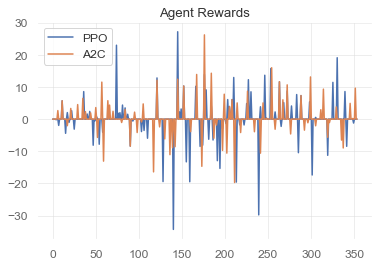

In [42]:
ModelCreation()

In [17]:
plt.figure(figsize=(16, 6))
for env in envs:
    env.render()
plt.show()

NameError: name 'envs' is not defined

<Figure size 1152x432 with 0 Axes>

In [56]:
env.history

{}

In [54]:
qs.extend_pandas()

net_worth = pd.Series(env.history['total_profit'], index=data.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)

KeyError: 'total_profit'